In [1]:
import numpy as np
import argparse
import csv
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
np.random.seed(42)
import math
import random

In [112]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 20
NUM_ITER = 50000
MAX_POWER = 9
SUBSET = 20
N_FOLDS = 10
ERROR = "mse"
REGULARIZATION_LAMBDA = 0

In [109]:
def readData(filename):
    dataset = []
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            dataset.append([float(row[0]),float(row[1])])
    return dataset
dataset = readData('gaussian.csv')

In [110]:
dataset = dataset[:SUBSET]

In [5]:
# dataset = []
# for i in np.arange(0,2,0.02):
#     dataset.append([i,i*i*i*i-i*i*i-3*i*i+0.1*i+5])

In [6]:
def cross_validation_split(dataset):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / N_FOLDS)
    for i in range(N_FOLDS):
        fold = list()
        while len(fold) < fold_size:
            index = random.randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [7]:
# highest power is m here
def makeDesignMat(x,m):
    return np.vander(x,m+1,increasing=True)

In [8]:
def chunkarr(arr,n):
    return [arr[i:i + n] for i in range(0, len(arr), n)]

In [9]:
def plot_error(train_err_list,test_err_list):
    xa = np.linspace(1,len(train_err_list),len(train_err_list),dtype=int)
    plt.figure()
    plt.plot(xa,train_err_list,color="g")
    plt.plot(xa,test_err_list,color="r")
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.title('Error vs Iterations')
    plt.show()

In [98]:
def descent(trainX,y,testX,testY,lambd = 0.0, err_function = "mse" ):
    #m = len(trainX)
    w = np.random.rand(MAX_POWER+1)
    y = np.array(y)
    X = makeDesignMat(trainX,MAX_POWER)
    Xchunks = chunkarr(X,BATCH_SIZE)
    ychunks = chunkarr(y,BATCH_SIZE)
    train_err_list = []
    test_err_list = []
    lr = LEARNING_RATE
    for j in tqdm(range(NUM_ITER)):
        for chunk in range(len(Xchunks)):
            Xcon = Xchunks[chunk]
            ycon = ychunks[chunk]
            pred = np.dot(Xcon,w)
            test_err_list.append(testError(testX,testY,w))
            if err_function == "mse":
                err = 0.5 * (np.sum(np.square(pred-ycon)) + lambd*np.sum(np.square(w)))/len(ycon)
                #grad = (np.dot(Xcon.T,(pred-ycon)) + lambd*w)/len(ycon)
                grad = (np.dot(Xcon.T,(pred-ycon)) + lambd*w)
                grad = grad/np.linalg.norm(grad)
            if err_function == "mae":
                err = np.sum(np.abs(pred-ycon))
                parity = np.sign(pred - ycon)
                parity = parity.reshape((len(ycon),1))
                grad = np.sum(np.multiply(parity,Xcon).T,axis=1)/len(ycon)
            if err_function == "huber":
                e = 0.1
                temp = pred-ycon
                err = np.sum(np.where(np.abs(temp)<=e,0.5*temp*temp,(e*np.abs(temp) - 0.5*e*e)))
                err += lambd*np.sum(np.square(w))
                err /= len(ycon)
                grad = np.zeros((MAX_POWER+1,))
                for i in range(len(ycon)):
                    if np.abs(temp[i]<=e):
                        grad += temp[i]*Xcon[i,:]
                    else:
                        grad += e*np.sign(temp[i])*Xcon[i,:]
                grad+=2*lambd*w
                w = np.squeeze(w)
                #grad /=len(ycon)
                grad /= np.linalg.norm(grad)
                grad = np.squeeze(grad)
            w = w - lr * grad
            train_err_list.append(err)
    plot_error(train_err_list,test_err_list)
    return w

In [11]:
def plot_reg(trainX,trainY,testX,testY,w):
    def aux(X_line,w):
        temp = 0
        for i in range(len(w)):
            temp += np.power(X_line,i) * w[i]
        return temp
    jointX = np.concatenate((trainX,testX))
    plt.scatter(trainX,trainY,color='b',marker ='o',s=15)
    plt.scatter(testX,testY,color="m",marker='o',s=30)
    x_line = np.linspace(min(jointX),max(jointX),100)
    y_pred = aux(x_line,w)
    plt.plot(x_line,y_pred, color='g')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.show()

In [12]:
def testError(testX, testY,w):
    testX = makeDesignMat(testX,MAX_POWER)
    pred = np.dot(testX,w)
    if ERROR == "mse":
        err = 0.5 * (np.sum(np.square(pred-testY)))/len(testY)
    elif ERROR == "mae":
        err = np.sum(np.abs(pred-testY)) / len(testY)
    elif ERROR == "huber":
        e = 0.1
        temp = pred-testY
        err = np.sum(np.where(np.abs(temp)<=e,0.5*temp*temp,(e*np.abs(temp) - 0.5*e*e))) / len(testY)
    return err

In [37]:
def evaluate(dataset):
    folds = cross_validation_split(dataset)
    err_list = []
    for fold in folds:
        trainDS = list(folds)
        trainDS.remove(fold)
        trainDS = np.array(trainDS)
        trainX = []
        trainY = []
        for i in range(len(trainDS)):
            trainX.extend(trainDS[i][:,0])
            trainY.extend(trainDS[i][:,1])
        testDS = np.array(fold)
        testX = testDS[:,0]
        testY = testDS[:,1]
        w = descent(trainX,trainY,testX,testY,REGULARIZATION_LAMBDA,ERROR)
        plot_reg(trainX,trainY,testX,testY,w)
        err = testError(testX,testY,w)
        err_list.append(err)
    avg_error = np.mean(err_list)
    #print(err_list)
    return avg_error

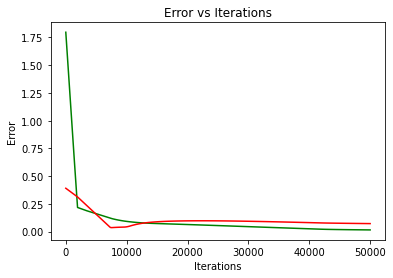

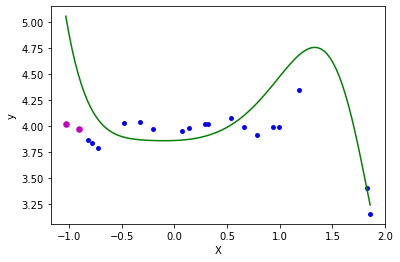

KeyboardInterrupt: 

In [113]:
evaluate(dataset)

In [94]:
def evaluate_moorepenrose(dataset):
    folds = cross_validation_split(dataset)
    err_list = []
    for fold in folds:
        trainDS = list(folds)
        trainDS.remove(fold)
        trainDS = np.array(trainDS)
        trainX = []
        trainY = []
        for i in range(len(trainDS)):
            trainX.extend(trainDS[i][:,0])
            trainY.extend(trainDS[i][:,1])
        testDS = np.array(fold)
        testX = testDS[:,0]
        testY = testDS[:,1]
        X = makeDesignMat(trainX,MAX_POWER)
        #w = np.dot(np.linalg.inv(np.dot(X.transpose(),X)),np.dot(X.transpose(),trainY))
        w = np.dot(np.linalg.inv(np.dot(X.transpose(),X) + REGULARIZATION_LAMBDA * np.identity(MAX_POWER+1) ),np.dot(X.transpose(),trainY))
        plot_reg(trainX,trainY,testX,testY,w)
        err = testError(testX,testY,w)
        err_list.append(err)
    avg_error = np.mean(err_list)
    print(w)
    print(err_list)
    return avg_error

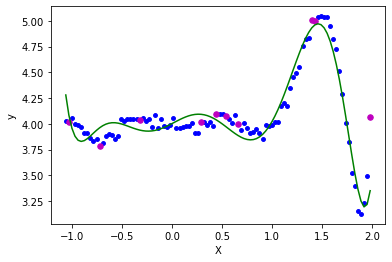

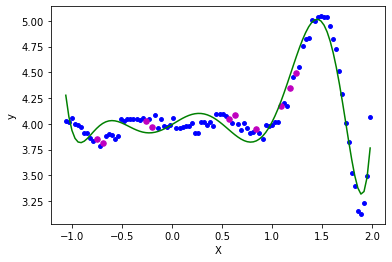

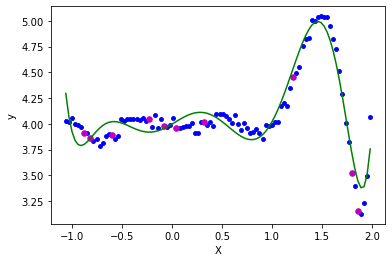

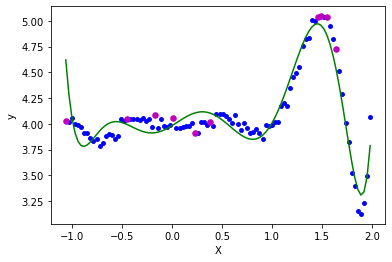

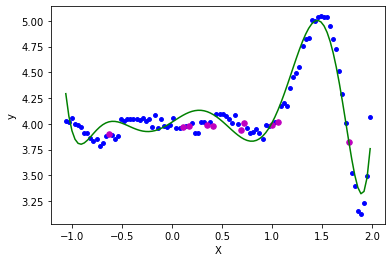

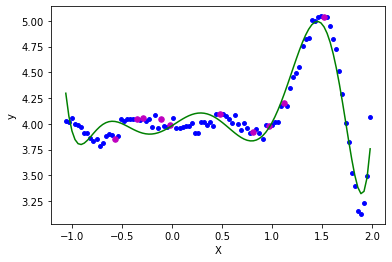

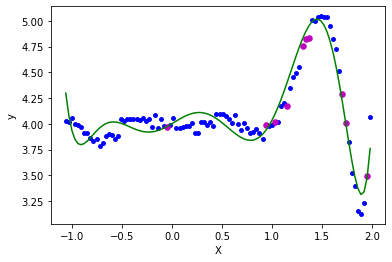

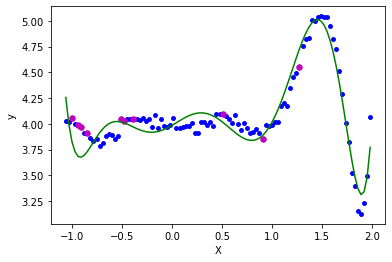

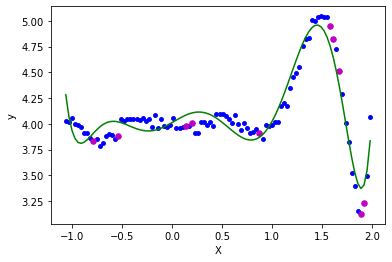

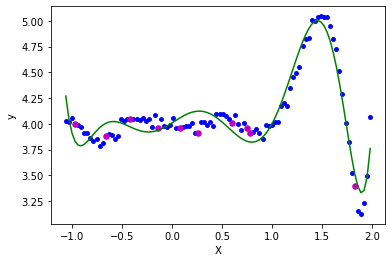

[ 4.00845903  0.61565409  0.27905068 -3.80359433 -1.04759343  6.34995931
 -0.29729056 -3.12026353  1.01598326]
[0.02950171999096236, 0.008245971775465285, 0.00962798378844635, 0.025815619868470134, 0.005746893768829529, 0.0052279718605896495, 0.004561497069723735, 0.015597371105890134, 0.011376369387014192, 0.007232865147174479]


0.012293426376256583

In [97]:
evaluate_moorepenrose(dataset)

In [ ]:
LEARNING_RATE = 1e-2
BATCH_SIZE = 10
NUM_ITER = 5000
MAX_POWER = 5
SUBSET = 100
N_FOLDS = 10
ERROR = "mse"
REGULARIZATION_LAMBDA = 0

In [23]:
minerr = 9999999999
ERROR = "mse"
N_FOLDS = 5
bestp,bestlr,bestiter,bestld,bestbs = 0,0,0,0,0
for MAX_POWER in tqdm([3,4,5,6,7,8,9,10]):
    for LEARNING_RATE in tqdm([1e-2,1e-4,1e-6,1e-8]):
        for NUM_ITER in tqdm([100,1000,10000]):
            for REGULARIZATION_LAMBDA in [1e-12,1e-5,1e-1]:
                for BATCH_SIZE in [4,8,16]:
                    #X = makeDesignMat(xsub,maxpow)
                    #w,err = descent(X,ysub,0,"mse")
                    err = evaluate(dataset)
                    if err<minerr:
                        bestp = MAX_POWER
                        bestlr = LEARNING_RATE
                        bestiter = NUM_ITER
                        bestld = REGULARIZATION_LAMBDA
                        bestbs = BATCH_SIZE
                        minerr = err
                        print(bestp,bestlr,bestiter,bestld,bestbs)

3 0.01 100 1e-12 4
3 0.01 1000 1e-12 4
3 0.01 10000 1e-05 8



4 0.01 100 1e-12 4
4 0.01 1000 1e-12 4
4 0.01 1000 1e-12 8
4 0.01 1000 1e-05 16
4 0.01 10000 1e-05 16
4 0.01 10000 0.1 16



5 0.01 10000 1e-12 16



c:\users\kshitij alwadhi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in square
  """
c:\users\kshitij alwadhi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in square
c:\users\kshitij alwadhi\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\users\kshitij alwadhi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in subtract
c:\users\kshitij alwadhi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars


In [24]:
bestp

5

In [25]:
bestlr

0.01

In [26]:
bestiter

10000

In [27]:
bestld

1e-12

In [28]:
bestbs

16

In [30]:
minerr = 9999999999
ERROR = "mse"
N_FOLDS = 5
bestp,bestlr,bestiter,bestld,bestbs = 0,0,0,0,0
for MAX_POWER in tqdm([9]):
    for LEARNING_RATE in tqdm([1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]):
        for NUM_ITER in tqdm([100,1000,10000]):
            for REGULARIZATION_LAMBDA in [1e-12]:
                for BATCH_SIZE in [8]:
                    #X = makeDesignMat(xsub,maxpow)
                    #w,err = descent(X,ysub,0,"mse")
                    err = evaluate(dataset)
                    if err<minerr:
                        bestp = MAX_POWER
                        bestlr = LEARNING_RATE
                        bestiter = NUM_ITER
                        bestld = REGULARIZATION_LAMBDA
                        bestbs = BATCH_SIZE
                        minerr = err
                        print(bestp,bestlr,bestiter,bestld,bestbs)

c:\users\kshitij alwadhi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in square
  """
c:\users\kshitij alwadhi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in square
c:\users\kshitij alwadhi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in subtract


9 0.0001 1000 1e-12 8



9 1e-05 10000 1e-12 8

